# Obligatorio Machine Learning para IA

### Ramiro Sanes y Joaquin Guerra

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import joblib
import imageio.v2 as imageio

from tqdm import tqdm
from random import sample
import seaborn as sns

from skimage import data, color
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.feature import hog
from skimage import exposure

from sklearn.feature_extraction.image import PatchExtractor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA

from utils import extract_patches

plt.style.use('ggplot')

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

In [9]:
images = []

# Creamos el directorio de Background si no existe
if not os.path.exists('Background'):
    os.makedirs('Background')
    #Descargamos el archivo zip de Background
    with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
        zip_ref.extractall('Background')

# Cargamos imagenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Cargamos imagenes de Background
# iteramos en todas las files de background
for file in os.listdir('Background'):
    if file.endswith('.jpg'):
        filename = os.path.join('Background', file)
        img = plt.imread(filename)
        if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
            img = color.rgb2gray(img)
        images.append(resize(img, (100,100)))

# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 150, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape


Procesando imágenes: 100%|██████████| 40/40 [00:14<00:00,  2.70it/s]


(30000, 64, 64)

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [10]:
faces = []

#Cargamos caras
if not os.path.exists('Faces'):
    os.makedirs('Faces')
    with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
        zip_ref.extractall()


all_files = os.listdir('Faces')
pgm_files = [filename for filename in all_files if filename.endswith('.pgm')]

for filename in tqdm(pgm_files):
    path = os.path.join('Faces', filename)
    image = imageio.imread(path)  
    faces.append(image)

faces_array = np.stack(faces)
faces_array = faces_array / 255.0

100%|██████████| 12833/12833 [03:25<00:00, 62.36it/s]


In [11]:
  # Etiquetas para las imágenes de rostros
X_faces = faces_array
y_faces = [1] * len(X_faces)

 # Etiquetas para las imágenes de fondo
X_fondos = negative_patches
y_fondos = [0] * len(X_fondos) 

# Etiquetas combinadas
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])  

Agregar lo de visualizacion en otro arrei

In [12]:
#Obtenemos hog features para las imagenes en X
hog_features = []
# Si existe el archivo hog_features.npy, lo cargamos
if os.path.exists('hog_features.npz'):
    hog_features = np.load('hog_features.npz')
else:
    for img in tqdm(X, desc='Extrayendo HOG features'):
        fd = hog(img, visualize=False)
        hog_features.append(fd)
    #Guardamos las features en un archivo
    hog_features = np.array(hog_features)
    np.savez_compressed('hog_features.npz', array=hog_features)
 


Extrayendo HOG features:   1%|          | 404/42833 [00:35<1:01:40, 11.47it/s]


KeyboardInterrupt: 

In [ ]:
#Aplanamos las features
hog_features = np.vstack(hog_features)
X_flatten = np.array([im.flatten() for im in tqdm(hog_features, desc='Construyendo hog_features')])

Construyendo hog_features: 100%|██████████| 42833/42833 [00:00<00:00, 279696.88it/s]


In [ ]:
pca_values = [200, 400, 450] # Your desired components
pca_dict = {}

for i in pca_values:
    #Hacemos PCA para cada valor de componentes (PCA no incremental)
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_flatten)
    pca_dict[i] = pca



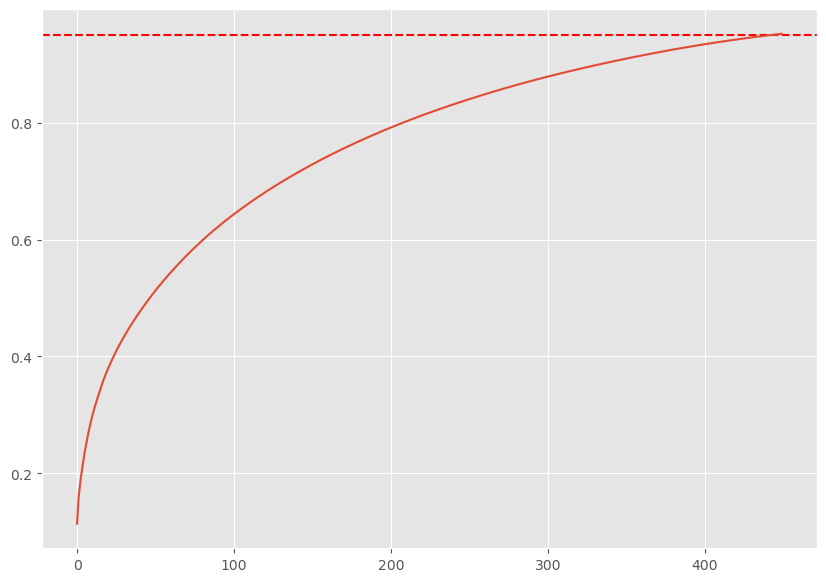

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.plot(np.cumsum(pca_dict[450].explained_variance_ratio_), label=f'{450} componentes')
plt.show()

Tomamos 450 como la cantidad de componentes principales ya que pasa el umbral definido de 95% de la varianza explicada 

In [ ]:
pca_final = pca_dict[450]

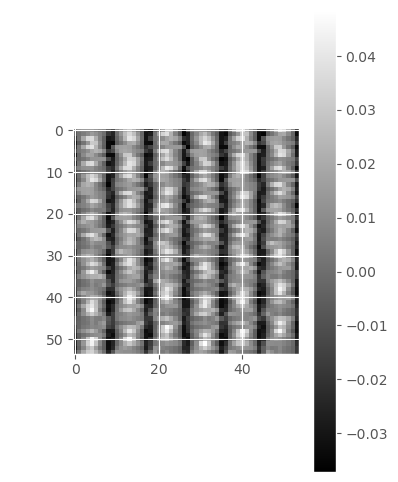

In [ ]:
pc1 = pca_final.components_[0]  # Shape: (4096,)

# Visualizar el hog como imagen
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(pc1.reshape(54, 54), cmap='gray')
plt.title("Primer componente principal (PC1)")
plt.colorbar()  
plt.show()

### Visualizamos las primeras componentes

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_flatten, y, test_size=0.1, random_state=42)

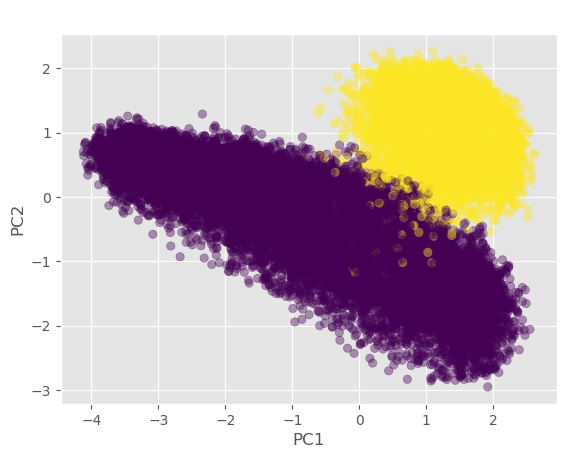

In [ ]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

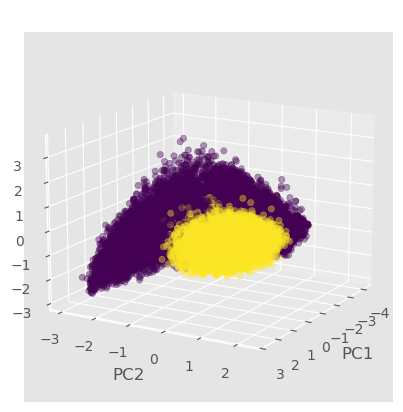

In [ ]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

In [ ]:
df = pd.DataFrame(X_pca_train, columns=[f'PC{i+1}' for i in range(X_pca_train.shape[1])])
df['y'] = y_train
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC442,PC443,PC444,PC445,PC446,PC447,PC448,PC449,PC450,y
0,-2.317531,0.194993,-1.115976,1.782362,-0.250600,-0.294712,-0.342024,0.493521,-0.929225,1.020525,...,-0.050844,0.046763,0.015249,0.053345,-0.046603,0.034038,-0.069162,-0.079882,0.032982,0
1,-0.781356,-0.063188,1.853203,0.477436,0.200280,0.203266,-0.040153,-0.703651,0.309372,0.005926,...,-0.046194,0.072925,0.024400,0.036990,0.107481,0.038615,0.049842,-0.081743,0.121797,0
2,0.317617,-1.624162,-0.246581,0.264855,-0.369321,0.846863,-1.317846,-0.514491,-0.550828,0.475491,...,-0.043058,-0.058691,-0.062795,-0.028709,0.059252,-0.024206,0.115591,0.084263,-0.064077,0
3,0.733359,0.889784,-0.421303,1.413334,-0.655531,-0.213118,-0.058306,-0.056393,0.309365,-1.027854,...,-0.086485,0.033570,0.154945,-0.043741,-0.050563,0.027518,0.070624,0.136049,-0.030813,1
4,-0.897323,-0.780823,-0.391975,2.600105,-0.050423,0.233914,-0.769485,0.533772,-0.687681,-0.160252,...,-0.104269,-0.032897,0.035068,0.218750,0.031497,0.155970,-0.169279,0.123386,-0.086460,0


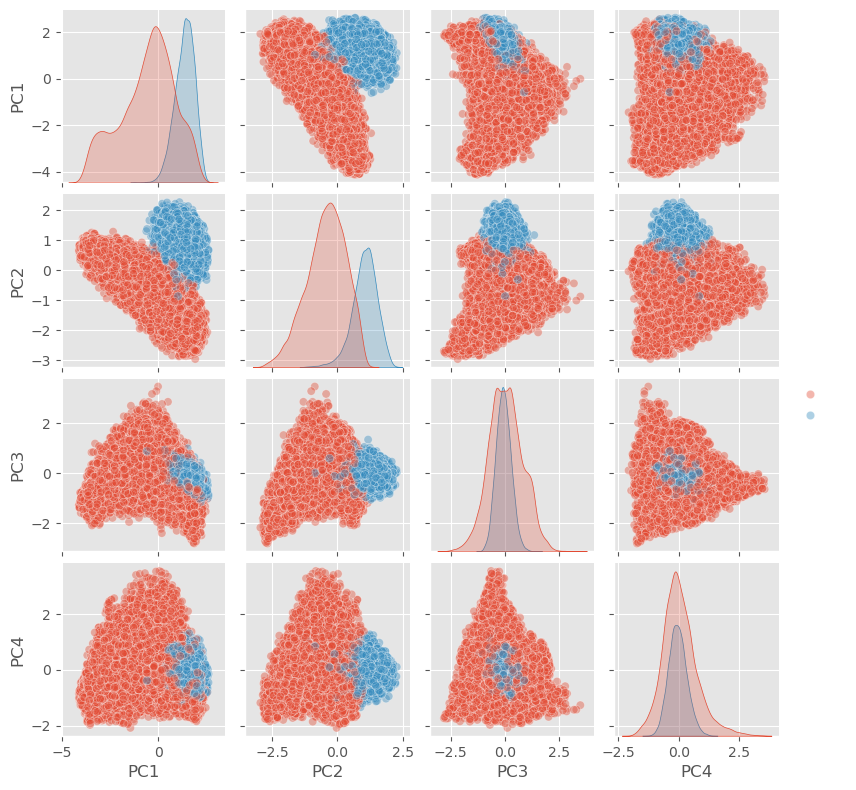

In [ ]:
sns.pairplot(df, vars=['PC1','PC2','PC3','PC4'], diag_kind='kde', height=2, plot_kws={'alpha':0.4}, hue='y',)
plt.show()

### Modelo sencillo de clasificación

In [ ]:
tree_dict = {}
scores = {}
for i in [2,5,10]:
    tree_dict[i] = DecisionTreeClassifier(max_depth=i,random_state=42)
    tree_dict[i].fit(X_pca_train, y_train)
    scores[i] = cross_val_score(tree_dict[i], X_pca_train, y_train, cv=5, scoring='accuracy')
    print(f"Score con {i} profundidad: {np.mean(scores[i])}")


Score con 2 profundidad: 0.9508937639045708
Score con 5 profundidad: 0.9913875724955705
Score con 10 profundidad: 0.9908947330078425


In [ ]:
X_pca_val = pca_final.transform(X_val)

In [ ]:
test_accuracies = {}
for i in [2,5,10]:
    test_accuracies[i] = tree_dict[i].score(X_pca_val, y_val)
    print("Accuracy en test con profundidad", i, ":", test_accuracies[i])

Accuracy en test con profundidad 2 : 0.9495798319327731
Accuracy en test con profundidad 5 : 0.9927637721755369
Accuracy en test con profundidad 10 : 0.9915966386554622


### Probamos en Test

In [ ]:
import zipfile

with zipfile.ZipFile('Test.zip', 'r') as zip_ref:
    zip_ref.extractall('Test')

In [ ]:
suffix = '.pgm'

all_files = os.listdir('Test/Test')
pgm_files_test = [filename for filename in all_files if filename.endswith(suffix)]

In [ ]:
test_images = []
for filename in tqdm(pgm_files_test):
    path = os.path.join('Test/Test', filename)
    image = imageio.imread(path)  # mucho más rápido que plt.imread
    test_images.append(image)

In [ ]:
test_array = np.stack(test_images)

In [ ]:
test_array = test_array / 255.0

In [ ]:
test_array.shape

In [ ]:
X_test_flatten = np.array([im.flatten() for im in tqdm(test_array, desc='Construyendo X')])

In [ ]:
print("Media - Test:", np.mean(X_test_flatten))

In [ ]:
# vuelvo X_test_flatten a su forma original y muestro 10 random
X_test_reshaped = X_test_flatten.reshape(-1, 64, 64)
samples = sample(range(X_test_reshaped.shape[0]), 10)
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test_reshaped[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
X_test_pca = pca_final.transform(X_test_flatten)

In [ ]:
y_test = tree_dict[10].predict(X_test_pca)

In [ ]:
test_df = pd.DataFrame(X_test_flatten)

In [ ]:
test_df['prediccion'] = y_test

In [ ]:
test_df.value_counts('prediccion')

In [ ]:
# muestro 10 imagenes de test_df que tengan prediccion 1
samples = sample(test_df[test_df['prediccion'] == 1].index.tolist(), 30)
fig, ax = plt.subplots(3, 10, figsize=(10, 4))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test_reshaped[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show() 

In [ ]:
joblib.dump(tree_dict[5], 'modelos/modelo_tree_10_285v2.pkl')

In [ ]:
joblib.dump(pca_final, 'modelos/pca_final_150_285v2.pkl')

In [ ]:
# Visualizamos una muestra
samples = sample(range(test_array.shape[0]), 30)
fig, ax = plt.subplots(6, 5, figsize=(5,6))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

Prueba Random Forest


In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rf_model.fit(X_pca_train, y_train)

In [ ]:
test_accuracy = rf_model.score(X_pca_val, y_val)
print("Accuracy en test:", test_accuracy)

Probamos en test Kaggle

In [ ]:
y_pred_rf_model = rf_model.predict(X_test_pca)

In [ ]:
df_pred_rf_model = pd.DataFrame(X_test_flatten)

In [ ]:
df_pred_rf_model['prediccion'] = y_pred_rf_model

In [ ]:
df_pred_rf_model.value_counts('prediccion')

In [ ]:
#imprimir las primeras 20 imagenes de test_array donde la prediccion es 1
samples = sample(range(test_array.shape[0]), 50)
fig, ax = plt.subplots(4, 12, figsize=(10, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(test_array[samples[i]], cmap='gray')
    axi.axis('off')
    axi.set_title(f"Predicción: {y_pred_rf_model[samples[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
test_df[0:50]['prediccion']

In [ ]:
# Obtengo de test_df los indices que tienen prediccion -1
indices_fondos = test_df[test_df['prediccion'] == -1].index
# Obtengo de test_df los indices que tienen prediccion 1
indices_caras = test_df[test_df['prediccion'] == 1].index

In [ ]:
#muestro las primeras 10 imagenes de test_array que tienen prediccion -1 a partir de indices_fondos
fig, ax = plt.subplots(4, 5, figsize=(4, 5), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()
for i in range(20):
    axes[i].imshow(test_array[indices_fondos[i]], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)


In [ ]:
gb_model.fit(X_pca_train, y_train)

In [ ]:
joblib.dump(gb_model, 'modelos/xgb_1.pkl')

In [ ]:
# Add HOG feature extraction function
def extract_hog_features(image):
    """
    Extract HOG features from an image
    Parameters:
    - image: Input image (must be 2D array)
    Returns:
    - features: HOG features
    - hog_image: Visualization of HOG features
    """
    features, hog_image = hog(
        image,
        orientations=9,           # 9 orientation bins
        pixels_per_cell=(8, 8),   # 8x8 pixels per cell
        cells_per_block=(2, 2),   # 2x2 cells per block
        visualize=True,           # Return both features and visualization
        block_norm='L2-Hys'       # Block normalization method
    )
    return features, hog_image

print("Comparing HOG features between faces and backgrounds...")

# Visualize HOG features for a sample face and background
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('HOG Feature Visualization')

# Face image example
face_idx = np.random.randint(len(X_faces))
face_img = X_faces[face_idx]
face_hog_features, face_hog_image = extract_hog_features(face_img)

axes[0,0].imshow(face_img, cmap='gray')
axes[0,0].set_title('Original Face')
axes[0,0].axis('off')

axes[0,1].imshow(face_hog_image, cmap='gray')
axes[0,1].set_title('HOG Features - Face')
axes[0,1].axis('off')

# Background image example
bg_idx = np.random.randint(len(X_fondos))
bg_img = X_fondos[bg_idx]
bg_hog_features, bg_hog_image = extract_hog_features(bg_img)

axes[1,0].imshow(bg_img, cmap='gray')
axes[1,0].set_title('Original Background')
axes[1,0].axis('off')

axes[1,1].imshow(bg_hog_image, cmap='gray')
axes[1,1].set_title('HOG Features - Background')
axes[1,1].axis('off')

# Add histograms of HOG features
axes[0,2].hist(face_hog_features, bins=50, density=True, alpha=0.7, color='blue')
axes[0,2].set_title('HOG Features Distribution - Face')
axes[1,2].hist(bg_hog_features, bins=50, density=True, alpha=0.7, color='red')
axes[1,2].set_title('HOG Features Distribution - Background')

plt.tight_layout()
plt.show()

print("\nExtracting HOG features for all images...")
# Extract HOG features for all images using tqdm for progress tracking
X_hog_faces = []
for img in tqdm(X_faces, desc='Processing faces'):
    features, _ = extract_hog_features(img)
    X_hog_faces.append(features)
X_hog_faces = np.array(X_hog_faces)

X_hog_backgrounds = []
for img in tqdm(X_fondos, desc='Processing backgrounds'):
    features, _ = extract_hog_features(img)
    X_hog_backgrounds.append(features)
X_hog_backgrounds = np.array(X_hog_backgrounds)

# Combine features and labels
X_hog = np.vstack([X_hog_faces, X_hog_backgrounds])
y_hog = np.hstack([y_faces, y_fondos])

# Split the data
X_hog_train, X_hog_val, y_hog_train, y_hog_val = train_test_split(
    X_hog, y_hog, test_size=0.1, random_state=42
)

print("\nTraining Random Forest classifier on HOG features...")
# Train a classifier (Random Forest) on HOG features
rf_hog = RandomForestClassifier(n_estimators=100, random_state=42)
rf_hog.fit(X_hog_train, y_hog_train)

# Evaluate the model
hog_train_score = rf_hog.score(X_hog_train, y_hog_train)
hog_val_score = rf_hog.score(X_hog_val, y_hog_val)

print(f"HOG Features - Training accuracy: {hog_train_score:.3f}")
print(f"HOG Features - Validation accuracy: {hog_val_score:.3f}")

# Compare feature importance
feature_importance = pd.DataFrame({
    'feature': range(len(rf_hog.feature_importances_)),
    'importance': rf_hog.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(range(20), feature_importance['importance'][:20])
plt.title('Top 20 Most Important HOG Features')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

# Save the HOG model
print("\nSaving HOG model...")
joblib.dump(rf_hog, 'modelos/rf_hog_model.pkl')